In [1]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import tqdm
import maxentep
# disabling gpu for now
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
EPS = np.finfo(np.float32).tiny
param_batch_size = 1024
maxent_batch_size = 32
sns.set_context('notebook')

## Set-up Starting Dist

In [2]:
M = 3
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.07681875, 0.54961444, 0.37356681],
        [0.2726723 , 0.56773941, 0.15958829],
        [0.44195761, 0.03325109, 0.5247913 ]]),
 array([1., 1., 1.]))

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 5, 3)
tmat.add_transition('A', 'I', 3, 2)
tmat.add_transition('I', 'R', 14, 5)

In [4]:
start_logits = np.ones((M,))

## Set-up unbiased Joint

In [5]:
unbiased_model = maxentep.ParameterJoint(start_logits, R, tmat, name='unbiased')
unbiased_model(tf.constant([1.]))

[<tfp.distributions.Independent 'unbiased_model_R_dist_dist_Independentunbiased_model_R_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3, 3] dtype=float32>,
 <tfp.distributions.Independent 'unbiased_model_T_dist_dist_Independentunbiased_model_T_dist_dist_unbiased_model_T_dist_dist_reciprocalunbiased_model_T_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3] dtype=float32>,
 <tfp.distributions.Blockwise 'unbiased_model_rho_dist_dist_Blockwise' batch_shape=[] event_shape=[6] dtype=float32>,
 <tfp.distributions.Independent 'unbiased_model_beta_dist_Independentunbiased_model_beta_dist_TruncatedNormal' batch_shape=[] event_shape=[1] dtype=float32>]

## Create Trainable Joint

In [6]:
model = maxentep.ParameterJoint(start_logits, R, tmat, name='param-model')

## Set-up loglikelihood

In [7]:
model.compile(tf.optimizers.Adam(1e-1))
model.summary()

Model: "param-model-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
R-dist-hypers (TrainableInputLa (None, 2, 3, 3)      18          input_2[0][0]                    
__________________________________________________________________________________________________
R-dist-jitter (Lambda)          (None, 2, 3, 3)      0           R-dist-hypers[0][0]              
__________________________________________________________________________________________________
T-dist-hypers (TrainableInputLa (None, 2, 4, 4)      32          input_2[0][0]                    
__________________________________________________________________________________

## Test out the prior distributions

In [8]:
p = model(tf.constant([1.]))
p

[<tfp.distributions.Independent 'param_model_model_R_dist_dist_Independentparam_model_model_R_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3, 3] dtype=float32>,
 <tfp.distributions.Independent 'param_model_model_T_dist_dist_Independentparam_model_model_T_dist_dist_param_model_model_T_dist_dist_reciprocalparam_model_model_T_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3] dtype=float32>,
 <tfp.distributions.Blockwise 'param_model_model_rho_dist_dist_Blockwise' batch_shape=[] event_shape=[6] dtype=float32>,
 <tfp.distributions.Independent 'param_model_model_beta_dist_Independentparam_model_model_beta_dist_TruncatedNormal' batch_shape=[] event_shape=[1] dtype=float32>]

In [9]:
p[1]

<tfp.distributions.Independent 'param_model_model_T_dist_dist_Independentparam_model_model_T_dist_dist_param_model_model_T_dist_dist_reciprocalparam_model_model_T_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3] dtype=float32>

In [10]:
p[1].sample(2)
p[1].log_prob(p[1].sample(2))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.3827591, 2.4710867], dtype=float32)>

In [11]:
s = [x.sample(2) for x in p]
print(s)

[<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
array([[[0.2490372 , 1.0260677 , 0.64674944],
        [0.0635017 , 0.8087082 , 0.32110977],
        [0.41770655, 0.25624442, 1.4068228 ]],

       [[0.6447292 , 0.51963454, 1.2735031 ],
        [0.2663049 , 0.81594497, 0.73467046],
        [0.69325244, 0.20551786, 0.950401  ]]], dtype=float32)>, <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.11597068, 0.51559854, 0.08383635],
       [0.1282239 , 0.5165215 , 0.05667529]], dtype=float32)>, <tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.        , 1.        , 0.        , 0.4737758 , 0.18836951,
        0.07981282],
       [1.        , 0.        , 0.        , 0.27572638, 0.38090128,
        0.2395342 ]], dtype=float32)>, <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.11053586],
       [0.20259362]], dtype=float32)>]


In [12]:
p[1].log_prob(s[1])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([3.7508974, 4.442786 ], dtype=float32)>

In [13]:
p[1]

<tfp.distributions.Independent 'param_model_model_T_dist_dist_Independentparam_model_model_T_dist_dist_param_model_model_T_dist_dist_reciprocalparam_model_model_T_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3] dtype=float32>

In [14]:
[pi.log_prob(si) for pi, si in zip(p, s)]

[<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.8842355, -2.7281933], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([3.7508974, 4.442786 ], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9378364 , 0.97157884], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.5508502, 1.0301278], dtype=float32)>]

In [15]:
model.evaluate(tf.constant([1., 1.]), s)

1/1 [==============================] - 0s 2ms/step - loss: -5.3263 - R-dist-dist_loss: 2.3062 - T-dist-dist_loss: -4.0968 - rho-dist-dist_loss: -0.9547 - beta-dist_loss: -2.5810


[-5.326313018798828,
 2.3062143325805664,
 -4.096841812133789,
 -0.9547076225280762,
 -2.5809779167175293]

## Sampling Functions

In [16]:
v = model.sample(2)
v

[<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
 array([[[0.2661845 , 0.95558584, 0.28672767],
         [1.1950812 , 1.3185245 , 1.1805419 ],
         [1.0361252 , 0.15334857, 0.24283803]],
 
        [[1.0299476 , 0.90259403, 0.8038518 ],
         [0.45383048, 0.6929861 , 0.24291804],
         [1.0031483 , 0.20800728, 0.20691907]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
 array([[[0.73546934, 0.2645307 , 0.        , 0.        ],
         [0.        , 0.8304775 , 0.16952255, 0.        ],
         [0.        , 0.        , 0.861762  , 0.13823801],
         [0.        , 0.        , 0.        , 1.        ]],
 
        [[0.7235712 , 0.27642882, 0.        , 0.        ],
         [0.        , 0.8669669 , 0.13303311, 0.        ],
         [0.        , 0.        , 0.8983681 , 0.10163187],
         [0.        , 0.        , 0.        , 1.        ]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
 array([[[0.        , 0.        , 0.        , 

c:\users\white\maxent\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explcit keyword will result in an error or misinterpretation.
  FutureWarning


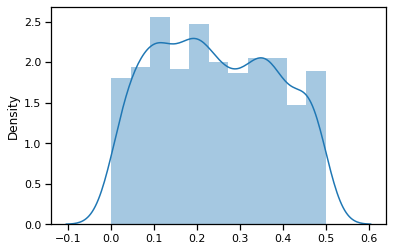

In [17]:
# sample start
s = model.sample(1000)[2].numpy().flatten()
sns.distplot(s[s > 0])

## Make some restraints

In [18]:
r1 = maxentep.Restraint(lambda x: x[...,25,0,2], 0.4, maxentep.EmptyPrior())
r2 = maxentep.Restraint(lambda x: x[...,50,0,2], 0.2, maxentep.EmptyPrior())

## Make Metapopulation Model

In [19]:
meta_model = maxentep.MetaModel(maxentep.contact_infection_func([1,2]), 150)

## Maxent Model

In [20]:
maxent_model = maxentep.MaxentModel([r1, r2])
maxent_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

## Visualize Unbiased

Text(0.5, 1.0, 'Unbiased Result')

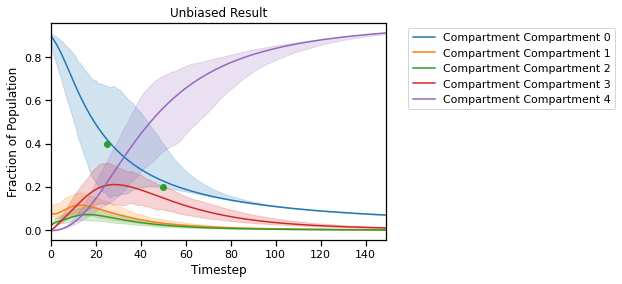

In [21]:
psample = unbiased_model.sample(param_batch_size)
trajs = meta_model(*psample)
maxentep.traj_quantile(trajs[:,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Unbiased Result')

## Try to reweight without hyper-parameter tuning

In [22]:
me_loss = []
# sample and get batch
psample = unbiased_model.sample(param_batch_size)
trajs = meta_model(*psample)
# get weights of trajectories
h = maxent_model.fit(trajs, batch_size=maxent_batch_size, epochs=128, verbose=False)
me_loss.extend(h.history['loss'])
w = maxent_model.traj_weights

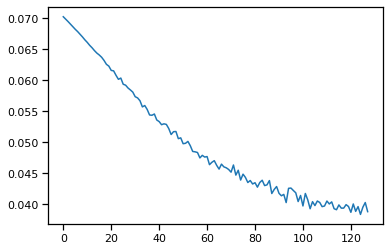

In [23]:
plt.plot(me_loss)
plt.show()

Text(0.5, 1.0, 'Maxent Result')

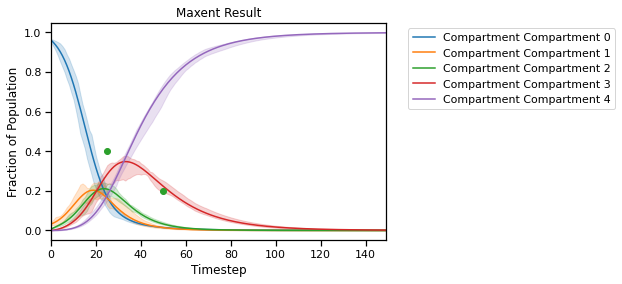

In [24]:
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result')

## Now tune hyperparameters at the same time

In [25]:
maxent_hyper_model = maxentep.HyperMaxentModel([r1, r2], model, meta_model)
maxent_hyper_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
maxent_hyper_model.fit(param_batch_size, 16, batch_size=32, epochs=8)

Epoch 1/8
32/32 [==============================] - 0s 531us/step - loss: 0.0702
Epoch 2/8
32/32 [==============================] - 0s 625us/step - loss: 0.0697
Epoch 3/8
32/32 [==============================] - 0s 563us/step - loss: 0.0693
Epoch 4/8
32/32 [==============================] - 0s 625us/step - loss: 0.0689
Epoch 5/8
32/32 [==============================] - 0s 594us/step - loss: 0.0685
Epoch 6/8
32/32 [==============================] - 0s 656us/step - loss: 0.0681
Epoch 7/8
32/32 [==============================] - 0s 687us/step - loss: 0.0677
Epoch 8/8
32/32 [==============================] - 0s 687us/step - loss: 0.0673
Epoch 1/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0368 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0035 - rho-dist-dist_loss: -9.6031e-04 - beta-dist_loss: -0.0357
Epoch 2/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0374 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0035 - rho-dist-dist_loss: -9.5776e-0

32/32 [==============================] - 0s 1ms/step - loss: -0.0367 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0037 - rho-dist-dist_loss: -9.7443e-04 - beta-dist_loss: -0.0352
Epoch 3/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0383 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0037 - rho-dist-dist_loss: -9.7172e-04 - beta-dist_loss: -0.0369
Epoch 4/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0384 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0037 - rho-dist-dist_loss: -9.6712e-04 - beta-dist_loss: -0.0370
Epoch 5/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0383 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0037 - rho-dist-dist_loss: -9.6801e-04 - beta-dist_loss: -0.0368
Epoch 6/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0388 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0037 - rho-dist-dist_loss: -9.7009e-04 - beta-dist_loss: -0.0373
Epoch 7/8
32/32 [=======================

32/32 [==============================] - 0s 625us/step - loss: 0.0395
Epoch 5/8
32/32 [==============================] - 0s 625us/step - loss: 0.0389
Epoch 6/8
32/32 [==============================] - 0s 719us/step - loss: 0.0385
Epoch 7/8
32/32 [==============================] - 0s 656us/step - loss: 0.0385
Epoch 8/8
32/32 [==============================] - 0s 656us/step - loss: 0.0381
Epoch 1/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0409 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0044 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0387
Epoch 2/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0418 - R-dist-dist_loss: 0.0032 - T-dist-dist_loss: -0.0044 - rho-dist-dist_loss: -9.7799e-04 - beta-dist_loss: -0.0397
Epoch 3/8
32/32 [==============================] - 0s 1ms/step - loss: -0.0410 - R-dist-dist_loss: 0.0033 - T-dist-dist_loss: -0.0044 - rho-dist-dist_loss: -0.0010 - beta-dist_loss: -0.0390
Epoch 4/8
32/32 [===================

## Compare Weights

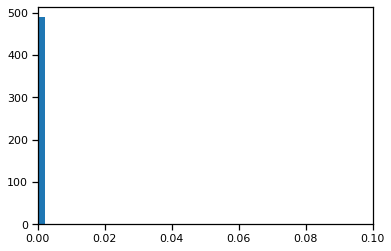

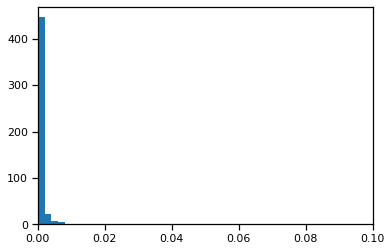

In [26]:
plt.hist(x=maxent_hyper_model.traj_weights, bins=np.linspace(0,0.1,50), density=True)
plt.xlim(0,0.1)
plt.show()
plt.hist(x=maxent_model.traj_weights, bins=np.linspace(0,0.1,50), density=True)
plt.xlim(0,0.1)
plt.show()

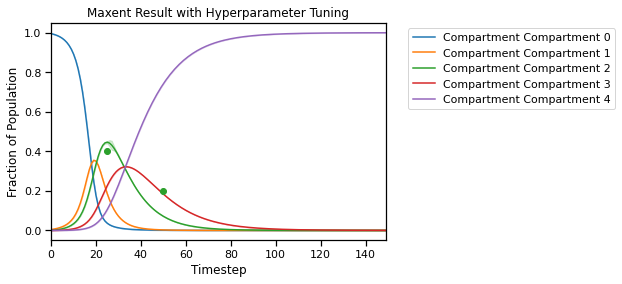

Text(0.5, 1.0, 'Maxent Result with Hyperparameter Tuning - Patch 2')

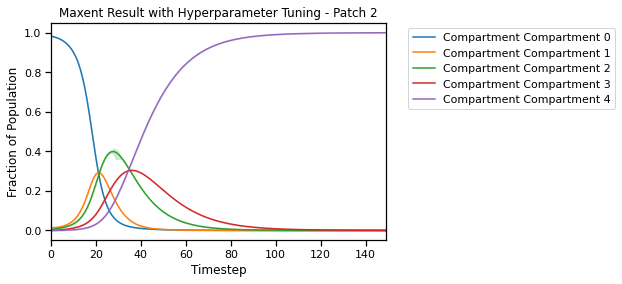

In [27]:
w = maxent_hyper_model.traj_weights
trajs = maxent_hyper_model.trajs
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result with Hyperparameter Tuning')
plt.show()

maxentep.traj_quantile(trajs[:,:,2,:], weights=w)
plt.title('Maxent Result with Hyperparameter Tuning - Patch 2')

## Compare Hyper-parameter values

<BarContainer object of 32 artists>

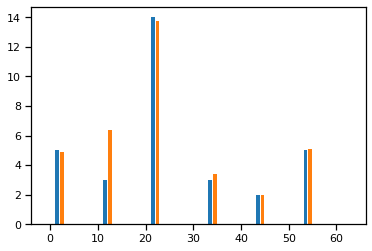

In [28]:
ub = unbiased_model.get_layer('T-dist-hypers').w.numpy().flatten()
b = model.get_layer('T-dist-hypers').w.numpy().flatten()
plt.bar(np.arange(len(ub)) * 2 - 0.5, ub)
plt.bar(np.arange(len(ub)) * 2 + 0.5, b)

<BarContainer object of 3 artists>

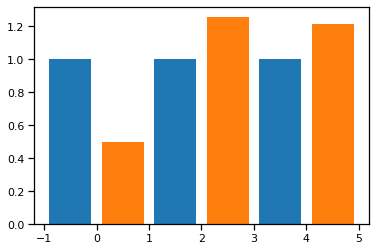

In [29]:
ub = unbiased_model.get_layer('rho-dist-start-logit-hypers').w.numpy().flatten()
b = model.get_layer('rho-dist-start-logit-hypers').w.numpy().flatten()
plt.bar(np.arange(len(ub)) * 2 - 0.5, ub)
plt.bar(np.arange(len(ub)) * 2 + 0.5, b)

<BarContainer object of 2 artists>

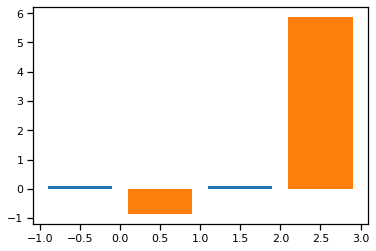

In [30]:
ub = unbiased_model.get_layer('rho-dist-norm-hypers').trainable_variables[0].numpy().flatten()
b = model.get_layer('rho-dist-norm-hypers').trainable_variables[0].numpy().flatten()
plt.bar(np.arange(len(ub)) * 2 - 0.5, ub)
plt.bar(np.arange(len(ub)) * 2 + 0.5, b)

## Now compare with Directed regression

In [31]:
infect = maxentep.ContactInfectionLayer(0.1, tmat.infectious_compartments)
start = np.zeros((M, C))
start[0,0] = 0.2
reg_model = maxentep.TrainableMetaModel(start, R, tmat.value, infect, 100, lambda traj: (r1(traj)**2 + r2(traj)**2))

In [32]:
reg_model.compile(optimizer=tf.keras.optimizers.Adam(1e-2))
reg_model.fit(epochs=1, verbose=True)

100/100 [==============================] - 3s 33ms/step - loss: 0.0272 - output_2_loss: 0.0272


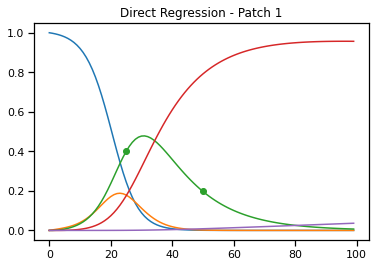

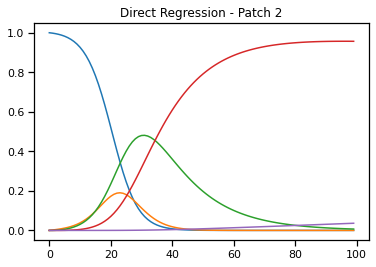

In [33]:
traj = reg_model.get_traj()
plt.plot(traj[0,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Direct Regression - Patch 1')
plt.show()
traj = reg_model.get_traj()
plt.plot(traj[0,:,1,:])
plt.title('Direct Regression - Patch 2')
plt.show()

In [34]:
reg_model.summary()

Model: "trainable_meta_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
trainable_input_layer (Train multiple                  9         
_________________________________________________________________
trainable_input_layer_1 (Tra multiple                  16        
_________________________________________________________________
trainable_input_layer_2 (Tra multiple                  12        
_________________________________________________________________
metapop_layer_1 (MetapopLaye multiple                  1         
_________________________________________________________________
traj (AddSusceptibleLayer)   multiple                  0         
_________________________________________________________________
lambda (Lambda)              multiple                  0         
Total params: 38
Trainable params: 38
Non-trainable params: 0
__________________________________________________

In [35]:
reg_model.layers[0].trainable_weights

[<tf.Variable 'value:0' shape=(3, 3) dtype=float32, numpy=
 array([[0.2221511 , 0.45925504, 0.3185938 ],
        [0.31163797, 0.44876248, 0.23959965],
        [0.4015469 , 0.19121696, 0.40723607]], dtype=float32)>]

In [36]:
reg_model.layers[1].trainable_weights

[<tf.Variable 'value:0' shape=(4, 4) dtype=float32, numpy=
 array([[7.1116924e-01, 2.8883076e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 9.3367547e-01, 6.6324592e-02, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 9.9937993e-01, 6.2007713e-04],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00]],
       dtype=float32)>]

In [37]:
reg_model.layers[2].trainable_weights

[<tf.Variable 'value:0' shape=(3, 4) dtype=float32, numpy=
 array([[-0.08503049, -0.16493118, -0.09526956, -0.09526958],
        [-0.06298754, -0.04107407, -0.05017067, -0.05017064],
        [-0.01124024,  0.01205881,  0.01205878,  0.01205879]],
       dtype=float32)>]

In [38]:
reg_model.layers[2].w.constraint(reg_model.layers[2].w)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[-0.08503045, -0.1649311 , -0.09526952, -0.09526953],
       [-0.06298748, -0.04107403, -0.05017062, -0.05017059],
       [-0.01124019,  0.01205876,  0.01205873,  0.01205874]],
      dtype=float32)>